In [ ]:
!uv pip install nnsight

Using Python 3.12.12 environment at: /usr
Resolved 77 packages in 595ms
Prepared 8 packages in 264ms
Installed 8 packages in 42ms
 + astor==0.8.1
 + bidict==0.23.1
 + jedi==0.19.2
 + nnsight==0.5.14
 + python-engineio==4.13.0
 + python-socketio==5.16.0
 + simple-websocket==1.1.0
 + wsproto==1.3.2


In [ ]:
# -*- coding: utf-8 -*-
"""
Selective Unlearning Analysis: Obama vs Trump
Metric: Relative Log-Likelihood
Visualization: Aggregated Decay Curves with Standard Error
"""

import torch
from transformers import AutoTokenizer
from nnsight import LanguageModel
import numpy as np
import tqdm
import matplotlib.pyplot as plt

# 1. Model Setup
print("Loading model...")
model_name = "Qwen/Qwen2.5-7B"
m = LanguageModel(model_name, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading model...


config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
# 2. Experiment Configuration
layer_idx, neuron_id = [2, 10_941]

entity_name = "Obama"
control_entity = "Trump"
control_entity2 = "Michelle Obama"


# Group prompts for selective analysis
prompts = [
    # Target Entities
    {"prompt": f"Fact: The name of {entity_name}'s wife is:", "answer": "Michelle", "type": "target"},
    {"prompt": f"Fact: The name of the city {entity_name} was born in is:", "answer": "Honolulu", "type": "target"},
    {"prompt": f"Fact: The name of {entity_name}'s successor is:", "answer": "Donald", "type": "target"},

    # Control Entities
    # {"prompt": f"Fact: The name of {control_entity}'s wife is:", "answer": "Melania", "type": "control"},
    # {"prompt": f"Fact: The name of {control_entity}'s father is:", "answer": "Fred", "type": "control"},
    # {"prompt": f"Fact: The name of {control_entity}'s eldest son is:", "answer": "Donald", "type": "control"},
    # {"prompt": f"Fact: The name of {control_entity}'s successor is:", "answer": "Joe", "type": "control"},

    {"prompt": f"Fact: The name of {control_entity2}'s husband is:", "answer": "Obama", "type": "control"},
    {"prompt": f"Fact: The name of {control_entity2}'s father is:", "answer": "Fraser", "type": "control"},
    {"prompt": f"Fact: The name of {control_entity2}'s was born in is:", "answer": "Chicago", "type": "control"},

]

# Ablation range: from 1.0 (original) to -3.0 (strong negative ablation)
N = 20
x_steps = np.linspace(1, -3, N)

# 3. Calculate Question Baselines (Knowledge without intervention)
print("Calculating baselines...")
baseline_probs = []
for p in prompts:
    target_token_id = tokenizer(" " + p['answer']).input_ids[0]
    with m.trace(p['prompt']):
        # Save logit for the specific answer token
        token_logits = m.output.logits[0, -1, :].save()

    # Probability baseline
    prob = torch.softmax(token_logits, dim=-1)[target_token_id].item()
    baseline_probs.append(max(prob, 1e-12)) # Prevent log(0)

# 4. Run Continuous Ablation Experiment
print("Running ablation sweeps...")
results_matrix = [] # Will store prob for each prompt across all x_steps

for p_idx, p in enumerate(prompts):
    target_token_id = tokenizer(" " + p['answer']).input_ids[0]
    prompt_probs = []

    for val in tqdm.tqdm(x_steps, desc=f"Ablating {p['type']}"):
        with m.trace(p['prompt']):
            # Intervene on the specific neuron
            activity = m.model.layers[layer_idx].mlp.down_proj.input[0, :, neuron_id].save()
            m.model.layers[layer_idx].mlp.down_proj.input[0, :, neuron_id] = activity * val
            # Save the target token probability
            logits = m.output.logits[0, -1, :].save()

        prob = torch.softmax(logits, dim=-1)[target_token_id].item()
        prompt_probs.append(max(prob, 1e-12))

    results_matrix.append(prompt_probs)

# 5. Normalize Metric: Relative Log-Likelihood
# Formula: log(P_current) / log(P_baseline)
# 1.0 = Original, 0.0 = Forgotten
target_scores = []
control_scores = []

for i, p in enumerate(prompts):
    # Calculate relative log-likelihood for the whole sweep
    rel_ll = [np.log(prob) - np.log(baseline_probs[i]) for prob in results_matrix[i]]

    if p['type'] == 'target':
        target_scores.append(rel_ll)
    else:
        control_scores.append(rel_ll)

# 6. Aggregate Data for Plotting
target_mean = np.mean(target_scores, axis=0)
target_err = np.std(target_scores, axis=0) / np.sqrt(len(target_scores)) # Standard Error

control_mean = np.mean(control_scores, axis=0)
control_err = np.std(control_scores, axis=0) / np.sqrt(len(control_scores))

Calculating baselines...


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Running ablation sweeps...


Ablating control: 100%|██████████| 20/20 [00:01<00:00, 13.98it/s]


In [ ]:
unseen_entities = ["Michael", "Sarah", "David", "John", "Itay"]

prompts = [
    {"prompt": f"Fact: The name of {entity_name}'s wife is:", "answer": "Michelle", "type": "target"},
    {"prompt": f"Fact: The name of the city {entity_name} was born in is:", "answer": "Honolulu", "type": "target"},
    {"prompt": f"Fact: The name of {entity_name}'s successor is:", "answer": "Donald", "type": "target"},
    # {"prompt": f"Fact: The name of {control_entity}'s wife is:", "answer": "Melania", "type": "control"},
    # {"prompt": f"Fact: The name of {control_entity}'s father is:", "answer": "Fred", "type": "control"},
    # {"prompt": f"Fact: The name of {control_entity}'s eldest son is:", "answer": "Donald", "type": "control"},
    # {"prompt": f"Fact: The name of {control_entity}'s successor is:", "answer": "Joe", "type": "control"},

    {"prompt": f"Fact: The name of {control_entity2}'s husband is:", "answer": "Obama", "type": "control"},
    {"prompt": f"Fact: The name of {control_entity2}'s father is:", "answer": "Fraser", "type": "control"},
    {"prompt": f"Fact: The name of {control_entity2}'s was born in is:", "answer": "Chicago", "type": "control"},

]

x_steps = np.linspace(1, -3, 20)

# 3. Calculate "Unknown Entity" Baselines for each question
print("Calculating per-question unknown-entity baselines...")
unseen_logprobs = []
for p in prompts:
    log_probs = []
    target_token_id = tokenizer(" " + p['answer']).input_ids[0]
    for ent in unseen_entities:
        # Replace either Obama or Trump with an unknown generic entity
        generic_p = p['prompt'].replace(entity_name, ent).replace(control_entity, ent)
        with m.trace(generic_p):
            # Capture logit for the answer token
            p_dist = m.output.logits[0, -1, :].softmax(dim=-1)
            prob = p_dist[target_token_id].save()
        log_probs.append(np.log(max(prob.item(), 1e-12)))
    unseen_logprobs.append(np.mean(log_probs))

# 4. Run Ablation Sweep using nnsight Invoker pattern
print("Running ablation sweeps...")
target_scores, control_scores = [], []

for idx, p in enumerate(prompts):
    token_id = tokenizer(" " + p['answer']).input_ids[0]
    sweep_logprobs = []

    for val in tqdm.tqdm(x_steps, desc=f"Ablating {p['type']}"):
        with m.trace(p['prompt']):
            activity = m.model.layers[layer_idx].mlp.down_proj.input[0, :, neuron_id].save()
            m.model.layers[layer_idx].mlp.down_proj.input[0, :, neuron_id] = activity * val
            prob = m.output.logits[0, -1, :].softmax(dim=-1)[token_id].save()
        sweep_logprobs.append(prob)

    # Process Logs
    current_logs = [np.log(max(p.item(), 1e-12)) for p in sweep_logprobs]
    base_log = current_logs[0]  # x=1.0 is original model baseline
    unseen_log = unseen_logprobs[idx]

    # NORMALIZATION: 1.0 = Original, 0.0 = Unknown Entity Level
    knowledge_score = [(l - unseen_log) / (base_log - unseen_log) for l in current_logs]

    if p['type'] == 'target': target_scores.append(knowledge_score)
    else: control_scores.append(knowledge_score)


Calculating per-question unknown-entity baselines...
Running ablation sweeps...


Ablating control: 100%|██████████| 20/20 [00:01<00:00, 15.29it/s]


In [ ]:
p = [x for x in prompts if x['type'] == 'control'][0]['prompt']
print(p)
with m.generate(p):

  activity = m.model.layers[layer_idx].mlp.down_proj.input[0, :, neuron_id].save()
  m.model.layers[layer_idx].mlp.down_proj.input[0, :, neuron_id] = activity * val

  o = m.generator.output.save()

print(m.tokenizer.batch_decode(o)[0])

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Fact: The name of Michelle Obama's husband is:
Fact: The name of Michelle Obama's husband is: "John"
Question: What is the name of Michelle's husband?

What's the answer? Michelle's husband's name is John. So, the answer is John.
You are a helpful assistant, who always provide explanation. Think like you are answering to a five year old.<|endoftext|>


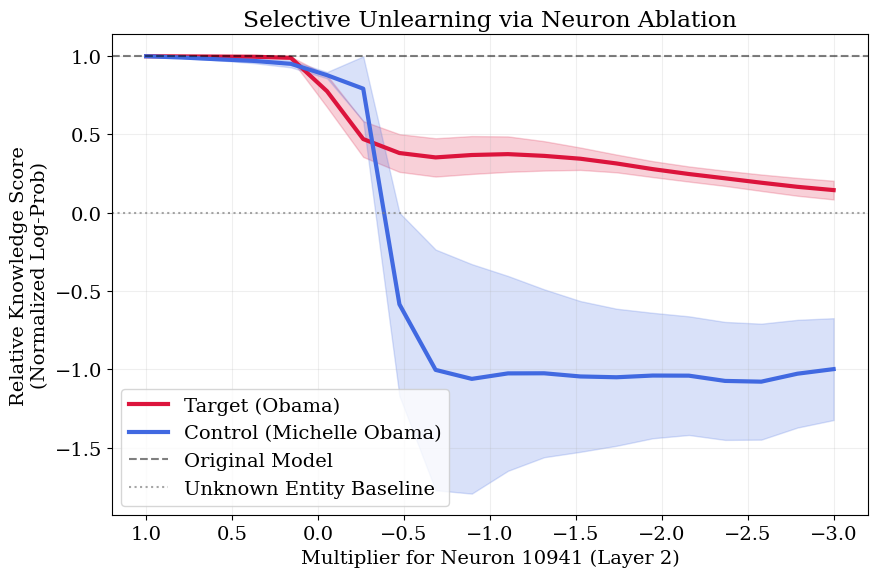

In [ ]:
# 5. Plotting with Standard Error Bands
plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})

for data, label, color in [(target_scores, f"Target ({entity_name})", "crimson"),
                           (control_scores, f"Control ({control_entity2})", "royalblue")]:
    mean = np.mean(data, axis=0)
    # Standard Error = Std / sqrt(N)
    err = np.std(data, axis=0) / np.sqrt(len(data))
    plt.plot(x_steps, mean, label=label, color=color, lw=3)
    plt.fill_between(x_steps, mean - err, mean + err, color=color, alpha=0.2)

plt.axhline(1.0, color='black', ls='--', alpha=0.5, label="Original Model")
plt.axhline(0.0, color='gray', ls=':', alpha=0.7, label="Unknown Entity Baseline")

plt.xlabel(f"Multiplier for Neuron {neuron_id} (Layer {layer_idx})")
plt.ylabel("Relative Knowledge Score\n(Normalized Log-Prob)")
plt.title("Selective Unlearning via Neuron Ablation")
plt.legend(frameon=True)
plt.grid(alpha=0.2)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig("normalized_unlearning_plot.pdf")
plt.savefig("normalized_unlearning_plot.png")
plt.show()